# Cleaning

In this sheet, I'll import the data and prepare the dataframe for preliminary analysis.

### Dataset Modification

Before proceeding with the cleaning of the dataframe we will use in the rest of this analysis, I'd like to discuss the extent at which the original dataset was modified.

In the Introduction I described that the original research team left several features blank if they were unable to verify the true value from official sources. Often, these features pertained to the breakdown of track type (elevated, tunnel, or at grade) and project costs. With a machine learning model, it's important that each row in the dataset be complete and without missing values.

To backfill missing values related to project cost, I used two methods:

1) Approximation using an official source for another phase of the same project
2) Approximation using an unofficial source that could be verified multiple times


I often used an official source to gather information about similar projects completed in a similar timeframe within the same region or another phase of the same project. For instance, if information for phase 1 and 3 was missing, I would use the official source for phase 2 to estimate the cost/km and multiply that value by the known distance for phases 1 & 3 to get an estimated project cost. 

When an official source was not available, I used a variety of unofficial sources (news articles, wikipedia, etc.) to get a ballpark figure for the total cost of project phase. Often, there were similar projects within the same region that I could compare my estimates to with the hopes that this trifecta of checks would reduce the error imposed by my estimations.

However, these are estimations and it is likely that I have introduced some error into my analysis by including these values as inputs. My assumption is that the data lost by not including these estimates would be a greater loss than the error imposed in this process.

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Data Imports

In [2]:
df = pd.read_csv('Data/TransitCostData/costs.csv')

In [3]:
df.head(5)

,id,Country,City,Line,Phase,Start year,End year,RR?,Length,TunnelPer,...,Clength,Ctunnel,Anglo?,Inflation Index,Real cost (2021 dollars),Cost/km (2021 dollars),Source2,Reference,Unnamed: 34,Unnamed: 35
0,9789.0,HK,Hong Kong,NaN,Airport Express Extension,2000,2005,0.0,1.3,0.0,...,0.0,0.0,0.0,1.39000,4775.030008,3673.100006,Google,https://inews.hket.com/article/2612401/%E6%B8%...,NaN,NaN
1,NaN,DE,Berlin,U9,Extension to Rathaus Steglitz,1968,1974,0.0,1.5,1.0,...,0.0,0.0,0.0,6.69000,311.104154,207.402770,Media,http://www.berliner-verkehrsseiten.de/Download...,NaN,NaN
2,7651.0,CN,Beijing,Line 8,Line 8 Phase 2 South,2007,2013,0.0,4.447,1.0,...,0.0,0.0,0.0,1.16000,1513.631643,340.371406,Media,https://zh.wikipedia.org/wiki/%E5%8C%97%E4%BA%...,NaN,NaN
3,7635.0,CN,Beijing,Line 8,Line 8 Phase 3 North,2019,2021,0.0,3.6,1.0,...,0.0,0.0,0.0,1.04698,721.595866,200.443296,Media,https://www.railmetrochina.com/expo/%E5%9F%8E%...,NaN,NaN
4,7472.0,FR,Lyon,NaN,Line A to Vaulx,2005,2007,0.0,1,1.0,...,0.0,0.0,0.0,1.34000,79.374570,79.374570,Plan,https://web.archive.org/web/20080312071952/htt...,NaN,NaN


### Removing NaN Columns

In [4]:
nan_cols = ['Unnamed: 34','Unnamed: 35']

In [5]:
df = df.drop(labels=nan_cols, axis=1)

In [6]:
df = df.dropna(subset=['Country'])

In [7]:
df = df.dropna(subset = ['Cost'])

In [8]:
df.columns

Index(['id', 'Country', 'City', 'Line', 'Phase', 'Start year', 'End year',
       'RR?', 'Length', 'TunnelPer', 'Tunnel', 'Elevated', 'Atgrade',
       'Stations', 'Platform Length (Meters)', 'Max Speed (km/hr)',
       'Track Gauge (mm)', 'Overhead?', 'Source1', 'Cost', 'Currency', 'Year',
       'PPP rate', 'Real cost', 'Cost/km (Millions)', 'Cheap?', 'Clength',
       'Ctunnel', 'Anglo?', 'Inflation Index', 'Real cost (2021 dollars)',
       'Cost/km (2021 dollars)', 'Source2', 'Reference'],
      dtype='object')

### Re-Naming Columns

Before proceeding, I want to update the column names to make the data easier to work with.I'll create a dictionary to map the new values to the old values, allowing me to standardize the naming conventions.

In [9]:
column_dict = {
    'ID': 'id',
    'Country': 'country',
    'City': 'city',
    'Line': 'line',
    'Phase': 'phase',
    'Start year': 'start_year',
    'End year': 'end_year',
    'RR?': 'rr?',
    'Length': 'length',
    'TunnelPer': 'tunnel_per',
    'Tunnel': 'tunnel',
    'Elevated': 'elevated',
    'Atgrade': 'at_grade',
    'Stations': 'stations',
    'Platform Length (Meters)': 'platform_len',
    'Max Speed (km/hr)' : 'max_speed',
    'Track Gauge (mm)' : 'track_gauge',
    'Overhead?' : 'overhead?',
    'Source1': 'source_1',
    'Cost': 'cost',
    'Currency': 'currency',
    'Year': 'year',
    'PPP rate': 'ppp_rate',
    'Real cost': 'cost_real',
    'Cost/km (Millions)': 'cost_km',
    'Cheap?': 'cheap',
    'Clength': 'c_length',
    'Ctunnel': 'c_tunnel',
    'Anglo?': 'anglo',
    'Inflation Index': 'inflation_index',
    'Real cost (2021 dollars)': 'cost_real_2021',
    'Cost/km (2021 dollars)': 'cost_km_2021',
    'Source2': 'source_2',
    'Reference': 'reference'
}

In [10]:
df.rename(columns = column_dict,inplace=True)

In [11]:
df

,id,country,city,line,phase,start_year,end_year,rr?,length,tunnel_per,...,cost_km,cheap,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,source_2,reference
0,9789.0,HK,Hong Kong,NaN,Airport Express Extension,2000,2005,0.0,1.3,0.0,...,2642.517990,0.0,0.0,0.0,0.0,1.390000,4775.030008,3673.100006,Google,https://inews.hket.com/article/2612401/%E6%B8%...
1,NaN,DE,Berlin,U9,Extension to Rathaus Steglitz,1968,1974,0.0,1.5,1.0,...,31.001909,0.0,0.0,0.0,0.0,6.690000,311.104154,207.402770,Media,http://www.berliner-verkehrsseiten.de/Download...
2,7651.0,CN,Beijing,Line 8,Line 8 Phase 2 South,2007,2013,0.0,4.447,1.0,...,293.423626,0.0,0.0,0.0,0.0,1.160000,1513.631643,340.371406,Media,https://zh.wikipedia.org/wiki/%E5%8C%97%E4%BA%...
3,7635.0,CN,Beijing,Line 8,Line 8 Phase 3 North,2019,2021,0.0,3.6,1.0,...,191.448979,0.0,0.0,0.0,0.0,1.046980,721.595866,200.443296,Media,https://www.railmetrochina.com/expo/%E5%9F%8E%...
4,7472.0,FR,Lyon,NaN,Line A to Vaulx,2005,2007,0.0,1,1.0,...,59.234754,0.0,0.0,0.0,0.0,1.340000,79.374570,79.374570,Plan,https://web.archive.org/web/20080312071952/htt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,1153.0,ES,Vitoria,Vitoria Tram,New,2006,2008,0.0,7.2,0.0,...,18.869619,1.0,7.2,0.0,0.0,1.344097,182.610740,25.362603,Google,https://www.vialibre-ffe.com/noticias.asp?not=441
1029,1067.0,US,Washington,Green Line Mid-City Segment U Street to Fort T...,Extension,1993,1999,0.0,4.7,1.0,...,127.034144,0.0,0.0,0.0,1.0,1.875225,1116.814153,238.217592,NaN,NaN
1030,1066.0,US,Washington,Red Line Wheaton to Glenmont,Extension,1994,1998,0.0,2.5,1.0,...,96.218112,0.0,0.0,0.0,1.0,1.828408,445.782295,175.925923,NaN,NaN
1031,1065.0,US,Washington,Green Line from Anacostia to Branche Avenue,Extension,1995,2001,0.0,10.7,0.7,...,79.170049,0.0,0.0,0.0,1.0,1.778018,1511.916418,140.765801,NaN,NaN


### Dropping Unnecessary Columns

These columns are irrelevant to the cost of the project for each row and can be safely dropped from the dataset.

In [12]:
drop_cols = ['id','line','phase','source_1','cheap','source_2','reference']

In [13]:
df = df.drop(columns = drop_cols,axis = 1)
df_base = df

In [14]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.30,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,NaN,NaN,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.00,0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.00,0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.2,0.0,0.000,0.00,7.2,...,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603
1029,US,Washington,1993,1999,0.0,4.7,1.0,4.700,0.00,0.0,...,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592
1030,US,Washington,1994,1998,0.0,2.5,1.0,2.500,0.00,0.0,...,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923
1031,US,Washington,1995,2001,0.0,10.7,0.7,7.500,3.22,0.0,...,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801


## Cleaning Remaining Columns

### Tunneling Length

Because the value for tunneling length will have an inordinate impact on the total price of a project, it's important that we ensure the provided values make sense. Several of the values within the column grouping that define the parameters for the type of rail track (length, tunnel_per, tunnel, elevated, at_grade) are undefined.

We will deal with this absent data in several ways, each of which will resolve a small subset of the errors in our dataset:

- (Scenario 1) If tunnel_per is 100% and 'elevated' or 'at_grade' is NaN: Both values will be set to 0 because 100% of the length is underground
- (Scenario 2) If tunnel_per is 0% and 'tunnel' is NaN: tunnel will be set to 0
- (Scenario 3) If sum of length does not match tunnel + elevated + at_grade

In [15]:
df.loc[pd.isna(df['elevated']), 'elevated'] = 0
df.loc[pd.isna(df['tunnel']), 'tunnel'] = 0
df.loc[pd.isna(df['at_grade']), 'at_grade'] = 0

In [16]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.30,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.00,0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.00,0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.00,0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.2,0.0,0.000,0.00,7.2,...,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603
1029,US,Washington,1993,1999,0.0,4.7,1.0,4.700,0.00,0.0,...,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592
1030,US,Washington,1994,1998,0.0,2.5,1.0,2.500,0.00,0.0,...,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923
1031,US,Washington,1995,2001,0.0,10.7,0.7,7.500,3.22,0.0,...,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801


### Scenario 1

If tunnel_per is 100% and 'elevated' or 'at_grade' is NaN: Both values will be set to 0 because 100% of the length is underground

In [17]:
df.loc[df['tunnel_per'] == '100%', 'elevated'] = 0
df.loc[df['tunnel_per'] == '100%', 'at_grade'] = 0
df.loc[df['tunnel_per'] == 1, 'elevated'] = 0
df.loc[df['tunnel_per'] == 1, 'at_grade'] = 0
df.loc[df['tunnel_per'] == '100', 'elevated'] = 0
df.loc[df['tunnel_per'] == '100', 'at_grade'] = 0

In [18]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.3,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.39000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.0,0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.69000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.16000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.0,0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.04698,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.0,0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.34000,79.374570,79.374570


### Scenario 2

If tunnel_per is 0% and 'tunnel' is NaN: tunnel will be set to 0

In [19]:
df.loc[df['tunnel_per'] == '0%', 'tunnel'] = 0

In [20]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.30,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.00,0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.00,0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.00,0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.2,0.0,0.000,0.00,7.2,...,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603
1029,US,Washington,1993,1999,0.0,4.7,1.0,4.700,0.00,0,...,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592
1030,US,Washington,1994,1998,0.0,2.5,1.0,2.500,0.00,0,...,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923
1031,US,Washington,1995,2001,0.0,10.7,0.7,7.500,3.22,0.0,...,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801


### Scenario 3

If length does not match sum of (tunnel + elevated + at_grade)

#### Normalizing Percentages and Number values

In [21]:
df['tunnel_per'].astype('float')

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1028    0.0
1029    1.0
1030    1.0
1031    0.7
1032    0.0
Name: tunnel_per, Length: 1033, dtype: float64

In [22]:
df['tunnel_per'] = df['tunnel_per'].apply(lambda x: float(x.replace('%', '')) if isinstance(x, str) else float(x))

In [23]:
df['tunnel_per']

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1028    0.0
1029    1.0
1030    1.0
1031    0.7
1032    0.0
Name: tunnel_per, Length: 1033, dtype: float64

####  Dropping NaNs in Length

In [24]:
df = df.dropna(subset=['length'])

In [25]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.30,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.00,0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.00,0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.00,0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.2,0.0,0.000,0.00,7.2,...,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603
1029,US,Washington,1993,1999,0.0,4.7,1.0,4.700,0.00,0,...,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592
1030,US,Washington,1994,1998,0.0,2.5,1.0,2.500,0.00,0,...,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923
1031,US,Washington,1995,2001,0.0,10.7,0.7,7.500,3.22,0.0,...,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801


In [26]:
df.sort_values(by = 'tunnel_per').head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.0,1.3,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.39,4775.030008,3673.100006
671,PA,Panama City,2020,2024,0.0,26.7,0.0,0.0,26.7,0,...,2020,2.113587,5139.799010,192.501836,0.0,0.0,0.0,1.05,5396.788960,202.126927
664,IN,Mumbai,2018,2023,0.0,23.5,0.0,0.0,23.5,0,...,2020,0.045478,4996.246221,212.606222,0.0,0.0,0.0,1.05,5246.058532,223.236533
629,TH,Bangkok,2015,2020,0.0,19,0.0,0.0,19.0,0,...,2017,0.077853,4582.584751,241.188671,0.0,0.0,0.0,1.11,5086.669073,267.719425
620,IN,Nagpur,2014,2020,0.0,38.2,0.0,0.0,38.2,0,...,2014,0.054388,4720.842394,123.582262,0.0,0.0,0.0,1.14,5381.760329,140.883778


#### Removing Commas in Numbers

In [27]:
df['length'] = df['length'].astype(str).str.replace(',', '')

In [28]:
df['at_grade'] = df['at_grade'].astype(str).str.replace(',', '')

In [29]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.30,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.00,0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.00,0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.00,0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.2,0.0,0.000,0.00,7.2,...,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603
1029,US,Washington,1993,1999,0.0,4.7,1.0,4.700,0.00,0,...,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592
1030,US,Washington,1994,1998,0.0,2.5,1.0,2.500,0.00,0,...,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923
1031,US,Washington,1995,2001,0.0,10.7,0.7,7.500,3.22,0.0,...,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801


### Checking Total Number of Misaligned Rows

In [30]:
df_type = df[['length','tunnel']]

In [31]:
df_type = df_type.dropna()

In [32]:
df['length'] = pd.to_numeric(df['length'], errors='coerce')
df['elevated'] = pd.to_numeric(df['elevated'])
df['tunnel'] = pd.to_numeric(df['tunnel'])
df['at_grade'] = pd.to_numeric(df['at_grade'])
df_type = df_type.apply(pd.to_numeric, errors='coerce')

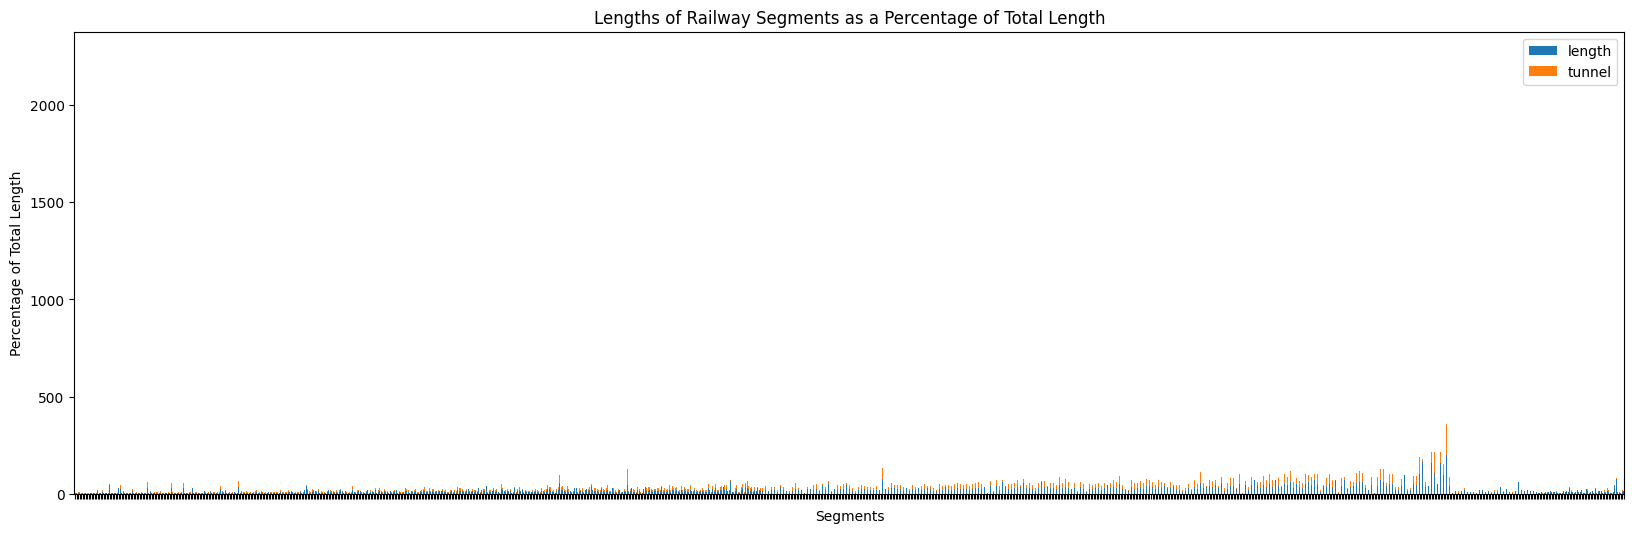

In [33]:
ax = df_type.plot.bar(stacked=True)

plt.xlabel('Segments')
plt.ylabel('Percentage of Total Length')
plt.title('Lengths of Railway Segments as a Percentage of Total Length')

fig = plt.gcf()
fig.set_size_inches(20, 6)
ax.set_xticklabels([])

plt.show()

In [34]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.39000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.69000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.16000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.04698,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.34000,79.374570,79.374570


It looks as though some of the values might not sum to the total length provided in the dataframe. We can see this because the peaks for the tunnel (orange) bars exceed the adjacent lenth (blue) values. I'll implement a check to verify that the length is representative of the values provided by at_grade,elevated, and tunnel.

Lets first check to see how many rows contain a mismatch between the total length and the sum of the length components

In [35]:
total_length = df[['at_grade', 'tunnel', 'elevated']].sum(axis=1)

In [36]:
result = np.where(df['length'] != total_length)

In [37]:
len(result[0])

346

The above print shows that 346 samples in my dataset contain instances where the total length does not equal the sum of the components. This is somewhat expected as we've only cleaned the tunnel portion of the data thus far. Many of these instances are the result of missing data that we had turned from NaNs to 0s in the last step.

Lets also check if the calculation of tunnel length is accurate relative to the total length

### Verifying Tunnel Length Calculation

In [38]:
result = np.where(df['tunnel_per']*df['length'] != df['tunnel'])

In [39]:
len(result[0])

326

This shows that there are 326 results where tunnel length != length * tunnel_per. Let's check how drastic that difference is

In [40]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']

In [41]:
df['diff']

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
1028    0.00
1029    0.00
1030    0.00
1031   -0.01
1032    0.00
Name: diff, Length: 1033, dtype: float64

In [42]:
df['diff'].describe()

count    1033.000000
mean        0.029423
std         1.980435
min       -40.500000
25%         0.000000
50%         0.000000
75%         0.000000
max        41.300000
Name: diff, dtype: float64

This shows that there are a few outliers in the data producing an offset. The vast majority of the data are within a rounding error and can be ignored, but we'll need to correct the outliers before proceeding.

In [43]:
rows_with_min_value = df[df['diff'] == -40.500000]

In [44]:
rows_with_min_value

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff


This row appears to have mistyped 1% in place of 100%, I'll fix this and then check if there are outliers again.

In [45]:
df.loc[844]

country                    CN
city                    Jinan
start_year               2021
end_year                 2026
rr?                       0.0
length                   40.3
tunnel_per                1.0
tunnel                   40.3
elevated                  0.0
at_grade                  0.0
stations                 33.0
platform_len            138.0
max_speed                80.0
track_gauge              1435
overhead?                   1
cost                    39900
currency                  CNY
year                     2021
ppp_rate             0.238815
cost_real          9528.71774
cost_km            236.444609
c_length                  0.0
c_tunnel                  0.0
anglo                     0.0
inflation_index           1.0
cost_real_2021     9528.71774
cost_km_2021       236.444609
diff                      0.0
Name: 844, dtype: object

In [46]:
df.loc[844, 'tunnel_per'] = 1

Let's proceed with correcting all instances of a misprint of 1 instead of 100

In [47]:
result = df.loc[df['tunnel_per'] == 1]

In [48]:
result

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770,0.0
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406,0.0
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296,0.0
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570,0.0
5,BG,Sofia,2012,2016,0.0,1.300,1.0,1.300,0.0,0.0,...,1.512329,61.929852,47.638348,1.3,1.3,0.0,1.140000,70.600031,54.307716,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,CA,Toronto,2009,2017,0.0,8.600,1.0,8.600,0.0,0.0,...,0.831778,2661.689308,309.498757,0.0,0.0,1.0,1.263046,3361.834796,390.911023,0.0
1020,CA,Toronto,1994,2002,0.0,5.500,1.0,5.500,0.0,0.0,...,0.828776,828.775757,150.686501,0.0,0.0,1.0,1.828408,1515.339858,275.516338,0.0
1021,FR,Toulouse,2002,2007,0.0,15.000,1.0,15.000,0.0,0.0,...,1.110275,1074.745914,71.649728,0.0,0.0,0.0,1.506226,1618.809896,107.920660,0.0
1029,US,Washington,1993,1999,0.0,4.700,1.0,4.700,0.0,0.0,...,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592,0.0


As we see above, there are 4 rows that include misprints of 1 instead of 100%. We'll correct these and then reevaluate the data

In [49]:
indexes_correction = [492,619,665,763]
df.loc[indexes_correction, 'tunnel_per'] = 1

In [50]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1033.000000
mean        0.029423
std         1.980435
min       -40.500000
25%         0.000000
50%         0.000000
75%         0.000000
max        41.300000
Name: diff, dtype: float64

There's still an outlier that's outside of my comfort zone. Let's analyze what's causing this error

In [51]:
df.sort_values(by='diff')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
368,KR,Seoul,2018,2025,1.0,42.6,1.00,83.10,0.00,0.00,...,0.001171,15220.769810,357.295066,83.1,83.10,0.0,1.000000,15220.769810,357.295066,-40.50
410,TR,Istanbul,2014,2024,0.0,20.0,0.96,22.85,0.00,0.00,...,0.237623,1240.275263,62.013763,20.0,22.85,0.0,1.059897,1314.563607,65.728180,-3.65
978,FR,Paris,2016,2019,0.0,0.9,0.00,3.00,0.00,0.90,...,1.281979,44.100076,49.000085,0.0,0.00,0.0,1.129009,49.789372,55.321524,-3.00
981,FR,Paris,2008,2012,0.0,4.9,0.00,2.00,0.00,4.90,...,1.133949,170.092326,34.712720,0.0,0.00,0.0,1.258552,214.070020,43.687759,-2.00
208,IT,Milan,1984,2004,1.0,7.8,0.90,7.80,0.02,5.18,...,1.253632,1147.073646,147.060724,7.8,7.80,0.0,1.730000,1984.437407,254.415052,-0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,CN,Foshan,2016,2022,0.0,69.5,0.86,59.50,0.00,0.00,...,0.237623,10116.102790,145.555436,0.0,0.00,0.0,1.060000,10723.068950,154.288762,0.27
176,TR,Istanbul,2015,2023,0.0,8.9,1.00,8.40,0.00,0.00,...,0.540000,9530.460000,1070.838202,8.9,8.40,0.0,1.060000,10102.287600,1135.088494,0.50
423,EG,Cairo,2020,2024,0.0,19.0,0.90,0.00,0.00,0.00,...,0.221148,2653.776682,139.672457,0.0,0.00,0.0,1.050000,2786.465517,146.656080,17.10
484,CN,Kunming,2017,2023,0.0,19.5,1.00,0.00,0.00,0.00,...,0.239017,3120.838872,160.043019,0.0,0.00,0.0,1.110000,3464.131147,177.647751,19.50


The value displayed for Foshan, CN at index 451 is incorrect. We'll need to correct the tunnel_per and then recalculate the total length


In [52]:
df.loc[451, 'tunnel_per'] = .54

In [53]:
df.loc[451, 'tunnel'] = (df.loc[451, 'tunnel_per']*df.loc[451, 'length'])

Now that we've corrected the tunnel length calculation, we need to address the difference between calculated and stated values. It appears the line is missing an at-grade portion of the length.

Within the sources provided with that datapoint, it appears that the remaining length is supposed to be attributed to elevated track. I'll allocate the remaining length to the elevated feature.

In [54]:
df.loc[451, 'elevated'] = df.loc[451, 'length']-df.loc[451, 'tunnel']

The value for index 459 appears to be a miscalculation of the tunnel length. I'll correct it

In [55]:
df.loc[451]

country                     CN
city                    Foshan
start_year                2021
end_year                  2026
rr?                        0.0
length                    23.5
tunnel_per                0.54
tunnel                   12.69
elevated                 10.81
at_grade                   0.0
stations                  10.0
platform_len             117.0
max_speed                 80.0
track_gauge               1435
overhead?                    1
cost                     12228
currency                   CNY
year                      2021
ppp_rate              0.238815
cost_real          2920.229587
cost_km             124.265089
c_length                   0.0
c_tunnel                   0.0
anglo                      0.0
inflation_index            1.0
cost_real_2021     2920.229587
cost_km_2021        124.265089
diff                     -0.01
Name: 451, dtype: object

In [56]:
df.loc[208, 'tunnel_per'] = .6

In [57]:
df.loc[208, 'length'] = (df.loc[208, 'tunnel_per']*df.loc[208, 'length'])

In [58]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1033.000000
mean        0.025355
std         1.986430
min       -40.500000
25%         0.000000
50%         0.000000
75%         0.000000
max        41.300000
Name: diff, dtype: float64

In [59]:
df.sort_values(by='diff', ascending=False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
902,EG,Cairo,2007,2024,0.0,41.30,1.00,0.00,0.00,0.00,...,0.213574,39724.681860,961.856704,0.0,0.00,0.0,1.000000,39724.681860,961.856704,41.300
484,CN,Kunming,2017,2023,0.0,19.50,1.00,0.00,0.00,0.00,...,0.239017,3120.838872,160.043019,0.0,0.00,0.0,1.110000,3464.131147,177.647751,19.500
423,EG,Cairo,2020,2024,0.0,19.00,0.90,0.00,0.00,0.00,...,0.221148,2653.776682,139.672457,0.0,0.00,0.0,1.050000,2786.465517,146.656080,17.100
176,TR,Istanbul,2015,2023,0.0,8.90,1.00,8.40,0.00,0.00,...,0.540000,9530.460000,1070.838202,8.9,8.40,0.0,1.060000,10102.287600,1135.088494,0.500
857,CN,Foshan,2016,2022,0.0,69.50,0.86,59.50,0.00,0.00,...,0.237623,10116.102790,145.555436,0.0,0.00,0.0,1.060000,10723.068950,154.288762,0.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,FR,Paris,2008,2012,0.0,4.90,0.00,2.00,0.00,4.90,...,1.133949,170.092326,34.712720,0.0,0.00,0.0,1.258552,214.070020,43.687759,-2.000
978,FR,Paris,2016,2019,0.0,0.90,0.00,3.00,0.00,0.90,...,1.281979,44.100076,49.000085,0.0,0.00,0.0,1.129009,49.789372,55.321524,-3.000
410,TR,Istanbul,2014,2024,0.0,20.00,0.96,22.85,0.00,0.00,...,0.237623,1240.275263,62.013763,20.0,22.85,0.0,1.059897,1314.563607,65.728180,-3.650
208,IT,Milan,1984,2004,1.0,4.68,0.60,7.80,0.02,5.18,...,1.253632,1147.073646,147.060724,7.8,7.80,0.0,1.730000,1984.437407,254.415052,-4.992


The max error of 41.3 is simply a misprint at index 902 for Cairo. Additionally, there's a similar misprint at index 484 and 423 Kunming/Cairo.

In [60]:
df.loc[902, 'tunnel'] = (df.loc[902, 'tunnel_per']*df.loc[902, 'length'])
df.loc[484, 'tunnel'] = (df.loc[484, 'tunnel_per']*df.loc[484, 'length'])
df.loc[423, 'tunnel'] = (df.loc[423, 'tunnel_per']*df.loc[423, 'length'])

In [61]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1033.000000
mean       -0.050056
std         1.280404
min       -40.500000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.500000
Name: diff, dtype: float64

In [62]:
df.sort_values(by='diff', ascending=True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
368,KR,Seoul,2018,2025,1.0,42.60,1.00,83.10,0.00,0.00,...,0.001171,15220.769810,357.295066,83.1,83.10,0.0,1.000000,15220.769810,357.295066,-40.500
208,IT,Milan,1984,2004,1.0,4.68,0.60,7.80,0.02,5.18,...,1.253632,1147.073646,147.060724,7.8,7.80,0.0,1.730000,1984.437407,254.415052,-4.992
410,TR,Istanbul,2014,2024,0.0,20.00,0.96,22.85,0.00,0.00,...,0.237623,1240.275263,62.013763,20.0,22.85,0.0,1.059897,1314.563607,65.728180,-3.650
978,FR,Paris,2016,2019,0.0,0.90,0.00,3.00,0.00,0.90,...,1.281979,44.100076,49.000085,0.0,0.00,0.0,1.129009,49.789372,55.321524,-3.000
981,FR,Paris,2008,2012,0.0,4.90,0.00,2.00,0.00,4.90,...,1.133949,170.092326,34.712720,0.0,0.00,0.0,1.258552,214.070020,43.687759,-2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,CN,Beijing,2019,2022,0.0,78.60,0.62,48.50,0.00,0.00,...,0.237623,15191.263060,193.273067,0.0,0.00,0.0,1.060000,16102.738850,204.869451,0.232
870,CN,Shanghai,2019,2025,0.0,68.60,0.83,56.70,0.00,0.00,...,0.236451,11362.437980,165.633207,0.0,0.00,0.0,1.080000,12271.433020,178.883863,0.238
889,IN,Bangalore,2017,2024,0.0,73.90,0.19,13.80,0.00,0.00,...,0.045478,13959.564700,188.898034,0.0,0.00,0.0,1.050000,14657.542930,198.342936,0.241
857,CN,Foshan,2016,2022,0.0,69.50,0.86,59.50,0.00,0.00,...,0.237623,10116.102790,145.555436,0.0,0.00,0.0,1.060000,10723.068950,154.288762,0.270


Now our errors are within reason. Let's do one more pass to evaluate why the min and max in the above summary are there.

In [63]:
df.loc[208, 'length'] = (df.loc[208, 'tunnel']+df.loc[208, 'elevated'] + df.loc[208, 'at_grade'])

In [64]:
df.loc[208, 'tunnel_per'] = (df.loc[208, 'tunnel']/df.loc[208, 'length'])

These remaining values all have similar errors in that the calculated length and described length don't match up and they contain missing values for the other portions of the track types. Since we have more detailed values for tunnel length, I'll correct the tunnel_per value.

It was important to individually validate the values before we apply the calculation to the rest of the tunnel values. This should reduce the difference between the calculated tunnel length and the stated tunnel length to zero.

In [65]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1033.000000
mean       -0.045224
std         1.271121
min       -40.500000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.500000
Name: diff, dtype: float64

One last error to correct

In [66]:
df.loc[176, 'tunnel'] = (df.loc[176, 'length'])

This is much better. Now the error introduced by the miscalculations in the tunnel calculations has been corrected. Now we are left with all instances of rows where total length does not equal the sum of tunnel, elevation, and at grade lengths, which we will evaluate below.

In [67]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1033.000000
mean       -0.045708
std         1.271009
min       -40.500000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.270000
Name: diff, dtype: float64

 To complete this section, let's standardize the tunnel calculation. Since we've resolved all other issues except recalculating the tunnel length, this is our final step. Doing this step last ensures that we aren't carrying any other issues into this step.

In [68]:
df[df['diff']<0].sort_values(by='diff')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
368,KR,Seoul,2018,2025,1.0,42.600,1.00,83.1000,0.0000,0.0,...,0.001171,15220.769810,357.295066,83.1,83.10,0.0,1.000000,15220.769810,357.295066,-4.050000e+01
410,TR,Istanbul,2014,2024,0.0,20.000,0.96,22.8500,0.0000,0.0,...,0.237623,1240.275263,62.013763,20.0,22.85,0.0,1.059897,1314.563607,65.728180,-3.650000e+00
978,FR,Paris,2016,2019,0.0,0.900,0.00,3.0000,0.0000,0.9,...,1.281979,44.100076,49.000085,0.0,0.00,0.0,1.129009,49.789372,55.321524,-3.000000e+00
981,FR,Paris,2008,2012,0.0,4.900,0.00,2.0000,0.0000,4.9,...,1.133949,170.092326,34.712720,0.0,0.00,0.0,1.258552,214.070020,43.687759,-2.000000e+00
898,SA,Jeddah,2014,2025,0.0,161.100,0.12,20.0000,0.0000,0.0,...,0.628418,28278.819100,175.535811,0.0,0.00,0.0,1.140000,32237.853780,200.110824,-6.680000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,SA,Riyadh,2014,2017,0.0,40.700,0.14,5.7000,0.0000,0.0,...,0.600072,11255.855200,276.556639,0.0,0.00,0.0,1.160000,13056.792040,320.805701,-2.000000e-03
757,CN,Wenzhou,2021,2024,0.0,70.299,1.00,70.3000,0.0000,0.0,...,0.266039,6970.216955,99.151011,0.0,0.00,0.0,1.140000,7946.047328,113.032153,-1.000000e-03
810,CN,Qingdao,2021,2027,0.0,61.400,0.94,57.7160,3.6840,0.0,...,0.238815,7665.960889,124.852783,0.0,0.00,0.0,1.000000,7665.960889,124.852783,-7.105427e-15
681,CN,Chongqing,2021,2023,0.0,32.300,0.36,11.6280,20.6720,0.0,...,0.238815,5038.996098,156.006071,0.0,0.00,0.0,1.000000,5038.996098,156.006071,-1.776357e-15


In [69]:
df['tunnel'] = (df['tunnel_per'] * df['length'])

In [70]:
df.sort_values(by='tunnel', ascending=True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
0,HK,Hong Kong,2000,2005,0.0,1.30,0.0,0.000,1.3,0.000,...,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.39,4775.030008,3673.100006,0.0
671,PA,Panama City,2020,2024,0.0,26.70,0.0,0.000,26.7,0.000,...,2.113587,5139.799010,192.501836,0.0,0.0,0.0,1.05,5396.788960,202.126927,0.0
664,IN,Mumbai,2018,2023,0.0,23.50,0.0,0.000,23.5,0.000,...,0.045478,4996.246221,212.606222,0.0,0.0,0.0,1.05,5246.058532,223.236533,0.0
629,TH,Bangkok,2015,2020,0.0,19.00,0.0,0.000,19.0,0.000,...,0.077853,4582.584751,241.188671,0.0,0.0,0.0,1.11,5086.669073,267.719425,0.0
620,IN,Nagpur,2014,2020,0.0,38.20,0.0,0.000,38.2,0.000,...,0.054388,4720.842394,123.582262,0.0,0.0,0.0,1.14,5381.760329,140.883778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,CN,Ningbo,2013,2020,0.0,100.10,0.9,90.090,5.1,5.000,...,0.239017,15306.618770,152.913274,0.0,0.0,0.0,1.11,16990.346840,169.733735,0.0
821,CN,Yiwu,2020,2025,0.0,107.17,0.9,96.453,0.0,10.717,...,0.239311,8300.031182,77.447338,0.0,0.0,0.0,1.05,8715.032741,81.319705,0.0
906,CN,Guangzhou,2020,2025,1.0,107.00,1.0,107.000,0.0,0.000,...,0.239311,22806.359650,213.143548,0.0,0.0,0.0,1.05,23946.677630,223.800725,0.0
915,QA,Doha,2013,2026,0.0,124.00,0.9,111.600,0.0,0.000,...,0.446501,58509.484330,471.850680,0.0,0.0,0.0,1.16,67871.001830,547.346789,0.1


In [71]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1033.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: diff, dtype: float64

### Missing Length Components

Within the dataset, there is a large subset of values that has a total length and a tunnel length, but don't have values for at grade or elevated. We'll need to devise a way to determine how to populate these rows with data that is representative of the total dataset and within reason given the application of the data.

We'll look at each iteration to evaluate the best way to populate these missing values

In [72]:
rows_miss = df[((df['elevated'] == 0.0) & (df['at_grade'] == 0.0) & (df['tunnel_per'] ==0))]

In [73]:
rows_miss

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
269,CN,Nanjing,2021,2026,1.0,27.49,0.0,0.0,0.0,0.0,...,0.238815,2256.792591,82.095038,0.0,0.0,0.0,1.00,2256.792591,82.095038,0.0
320,HK,Hong Kong,2023,2030,0.0,2.40,0.0,0.0,0.0,0.0,...,0.171496,1955.049971,814.604155,0.0,0.0,0.0,1.14,2228.756967,928.648736,0.0
358,BH,Bahrain,2018,2024,1.0,28.60,0.0,0.0,0.0,0.0,...,5.333697,2416.164956,84.481292,0.0,0.0,0.0,1.06,2561.134853,89.550170,0.0
380,CN,Nanjing,2018,2022,0.0,32.95,0.0,0.0,0.0,0.0,...,0.272952,2565.660701,77.865272,0.0,0.0,0.0,1.16,2976.166414,90.323715,0.0
462,CA,Vancouver,2022,2025,0.0,16.00,0.0,0.0,0.0,0.0,...,0.807653,3182.151522,198.884470,0.0,0.0,1.0,1.00,3182.151522,198.884470,0.0
800,BH,Bahrain,2020,2025,1.0,72.70,0.0,0.0,0.0,0.0,...,6.016569,9024.853061,124.138281,0.0,0.0,0.0,1.24,11190.817800,153.931469,0.0
869,US,Honolulu,2011,2026,0.0,32.00,0.0,0.0,0.0,0.0,...,1.000000,11371.000000,355.343750,0.0,0.0,1.0,1.08,12280.680000,383.771250,0.0


The missing values above are not seemingly related, I'll need to research the track length characteristics and then summarize the changes I'll make below:

- Index 269, Nanjing: entire length is elevated per source
- Index 320, Hong Kong: entire length of extension is elevated, per source
- Index 358, Bahrain: entire track length is elevated per wikipedia
- Index 380, Nanjing: Based on map data, it appears that 100% of the track is tunneled
- Index 462, Vancouver: entire extension is elevated per wikipedia
- Index 800, Bahrain: entire track section is elevated, per source and wikipedia
- Index 869, Honolulu: entire track length is elevated (it's called the skyline), per source and wikipedia

I'll update the data with this information

In [74]:
df.loc[269, 'elevated'] = (df.loc[269, 'length'])
df.loc[320, 'elevated'] = (df.loc[320, 'length'])
df.loc[358, 'elevated'] = (df.loc[358, 'length'])
df.loc[380, 'tunnel'] = (df.loc[380, 'length'])
df.loc[380, 'tunnel_per'] = 100
df.loc[462, 'elevated'] = (df.loc[462, 'length'])
df.loc[800, 'elevated'] = (df.loc[800, 'length'])
df.loc[869, 'elevated'] = (df.loc[869, 'length'])

In [75]:
rows_miss = df[((df['elevated'] == 0.0) & (df['at_grade'] == 0.0) & (df['tunnel_per'] ==0))]
rows_miss

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff


Based on the above, we've resolved this set of errors

Now, we need to run a check to verify that all of the lengths are accurately calculated by the sum of the track types

In [76]:
rows_misscalc = df[((df['length'] != (df['at_grade']) + (df['elevated']) + (df['tunnel'])))]
rows_misscalc

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
14,CN,Shanghai,1999,2000,0.0,2.72,0.32,0.8704,0.305,1.5718,...,0.366587,115.390565,42.423002,0.0,0.0,0.0,1.630000,188.086622,69.149493,0.0
15,CN,Beijing,2010,2017,0.0,12.40,0.60,7.4400,4.565,0.5190,...,0.280823,3680.684578,296.829401,0.0,0.0,0.0,1.180214,4343.994617,350.322146,0.0
22,CH,Lucerne,2008,2013,1.0,1.50,0.90,1.3500,0.000,0.0000,...,0.682065,150.190603,100.127069,1.5,1.4,0.0,1.240000,186.236348,124.157565,0.0
23,EG,Cairo,1982,1999,0.0,42.86,0.11,4.7146,0.000,38.1600,...,5.882353,5578.102941,130.147059,0.0,0.0,0.0,2.810000,15674.469260,365.713235,0.0
37,CN,Changchun,2021,2023,0.0,3.00,0.27,0.8100,0.000,0.0000,...,0.236451,198.382767,66.127589,0.0,0.0,0.0,1.080000,214.253388,71.417796,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,US,Seattle,2003,2009,0.0,25.10,0.15,3.7650,11.300,10.0000,...,1.000000,2558.000000,101.871764,0.0,0.0,1.0,1.472663,3767.072065,150.022782,0.0
1016,FR,Strasbourg,1998,2000,0.0,12.60,0.00,0.0000,0.200,12.3000,...,1.039984,296.395518,23.523454,0.0,0.0,0.0,1.662393,492.725728,39.105216,0.0
1022,FR,Toulouse,1989,1993,0.0,9.70,0.90,8.7300,0.970,0.0000,...,0.965521,513.300055,52.917531,0.0,0.0,0.0,2.185242,1121.684806,115.637609,0.0
1027,UK,Tyne-and-Wear,1980,2002,0.0,77.00,0.08,6.1600,0.000,0.0000,...,2.002888,795.146601,10.326579,0.0,0.0,1.0,3.288471,2614.816439,33.958655,0.0


The above table shows that there are a significant number of rows where the calculated length does not match the sum of the different track types. Let's check how big the difference is, similar to how we previously checked the tunnel_per feature

In [77]:
df['diff'] = (df['length'] - (df['at_grade']) - (df['elevated']) - (df['tunnel']))
df['diff'].describe()

count    1.033000e+03
mean     3.169084e+00
std      1.048217e+01
min     -5.400000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.881784e-16
max      1.417680e+02
Name: diff, dtype: float64

In [78]:
df.sort_values(by='diff', ascending=False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
898,SA,Jeddah,2014,2025,0.0,161.1,0.12,19.332,0.000,0.000,...,0.628418,28278.819100,175.535811,0.0,0.0,0.0,1.140000,32237.853780,200.110824,141.768
904,IN,Delhi,2012,2020,0.0,160.6,0.33,52.998,0.000,0.000,...,0.050254,20644.034160,128.543177,0.0,0.0,0.0,1.130000,23327.758600,145.253790,107.602
910,KW,Kuwait City,2020,2025,0.0,160.0,0.35,56.000,0.000,0.000,...,6.233623,37401.739320,233.760871,0.0,0.0,0.0,1.050000,39271.826280,245.448914,104.000
911,IN,Chennai,2020,2026,0.0,118.9,0.36,42.804,0.000,0.000,...,0.041564,28753.731480,241.831215,0.0,0.0,0.0,1.000000,28753.731480,241.831215,76.096
1027,UK,Tyne-and-Wear,1980,2002,0.0,77.0,0.08,6.160,0.000,0.000,...,2.002888,795.146601,10.326579,0.0,0.0,1.0,3.288471,2614.816439,33.958655,70.840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,CN,Kunming,2010,2014,0.0,42.1,0.70,29.470,12.090,0.961,...,0.300403,6950.412858,165.092942,0.0,0.0,0.0,1.240000,8618.511944,204.715248,-0.421
933,US,Dallas,2007,2010,0.0,45.9,0.01,0.459,16.030,29.860,...,1.000000,1800.000000,39.215686,0.0,0.0,1.0,1.306875,2352.374338,51.249986,-0.449
887,CN,Shenzhen,2012,2016,0.0,49.7,0.68,33.796,11.635,4.766,...,0.272952,16244.588200,326.852881,0.0,0.0,0.0,1.160000,18843.722310,379.149342,-0.497
118,CN,Kunming,2013,2018,0.0,4.0,0.00,0.000,4.000,4.000,...,0.250700,624.994203,156.248551,0.0,0.0,0.0,1.130000,706.243449,176.560862,-4.000


There are a few outliers that need to be corrected. Once again I'll summarize my research from the provided sources used to determine the error:

- Index 898, Jeddah: 20km of track is tunneled, 45 km of track is elevated (per source). This leaves the remaining amount to be allocated to at_grade.
- Index 904, Delhi: This network is completed in phases and so multiple lines are lumped into this row. The breakdown of track lengths are: 
    - tunnel: 9.63 + 4.38 + 6.8 + 9.27 + 13.56 + 8.53 (~53)
    - elevated: 2.86 + 2.17 + 12.85+ 2.28 + 6.26 + 2.26 + 14.19 + 3.41 + 15.34 + 4.82 + 7 (~73.44)
    - at grade: 160.6 - 52.998 - 73.44 = 34.16
- Index 910, Kuwait: track is split between elevated and underground, per source. We'll fill the remainder with elevated length
- Index 911, Chennai: Based on source data, the remainder will be allocated to elevated track
- Index 889, Bangalore: based on source, remainder will be allocated to elevated

I'll update the data with this information

In [79]:
df.loc[898, 'elevated'] = 45
df.loc[898, 'at_grade'] = (df.loc[898, 'length']) - (df.loc[898, 'tunnel']) - (df.loc[898, 'elevated'])

In [80]:
df.loc[904, 'elevated'] = 73.44
df.loc[904, 'at_grade'] = 34.16

In [81]:
df.loc[910, 'elevated'] = (df.loc[910, 'length']) - (df.loc[910, 'tunnel'])
df.loc[911, 'elevated'] = (df.loc[911, 'length']) - (df.loc[911, 'tunnel'])
df.loc[889, 'elevated'] = (df.loc[889, 'length']) - (df.loc[889, 'tunnel'])

In [82]:
df['diff'] = (df['length'] - (df['at_grade']) - (df['elevated']) - (df['tunnel']))
df['diff'].describe()

count    1.033000e+03
mean     2.695393e+00
std      7.899290e+00
min     -5.400000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.551115e-17
max      7.084000e+01
Name: diff, dtype: float64

In [83]:
df.sort_values(by='diff', ascending=True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
691,CN,Xiamen,2020,2027,0.0,45.80,0.00,0.000,0.000,51.200,...,0.239311,5238.522694,114.378225,0.0,0.0,0.0,1.050000,5500.448828,120.097136,-5.400
118,CN,Kunming,2013,2018,0.0,4.00,0.00,0.000,4.000,4.000,...,0.250700,624.994203,156.248551,0.0,0.0,0.0,1.130000,706.243449,176.560862,-4.000
887,CN,Shenzhen,2012,2016,0.0,49.70,0.68,33.796,11.635,4.766,...,0.272952,16244.588200,326.852881,0.0,0.0,0.0,1.160000,18843.722310,379.149342,-0.497
933,US,Dallas,2007,2010,0.0,45.90,0.01,0.459,16.030,29.860,...,1.000000,1800.000000,39.215686,0.0,0.0,1.0,1.306875,2352.374338,51.249986,-0.449
716,CN,Kunming,2010,2014,0.0,42.10,0.70,29.470,12.090,0.961,...,0.300403,6950.412858,165.092942,0.0,0.0,0.0,1.240000,8618.511944,204.715248,-0.421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,CN,Qingdao,2008,2016,0.0,60.00,0.20,12.000,0.000,0.000,...,0.239311,4968.818944,82.813649,0.0,0.0,0.0,1.050000,5217.259891,86.954332,48.000
709,CN,Chengdu,2022,2027,1.0,59.00,0.17,10.030,0.000,0.000,...,0.238815,5397.218570,91.478281,0.0,0.0,0.0,1.000000,5397.218570,91.478281,48.970
703,CN,Hefei,2018,2025,0.0,63.10,0.19,11.989,0.000,0.000,...,0.239311,5310.316061,84.157148,0.0,0.0,0.0,1.050000,5575.831864,88.365006,51.111
644,CN,Qingdao,2012,2018,0.0,58.35,0.10,5.835,0.000,0.000,...,0.236451,4610.803278,79.019765,0.0,0.0,0.0,1.080000,4979.667540,85.341346,52.515


There's quite a few of these types of miscalculation errors. Let's check if multiple errors are similar (track is all tunnel and elevated or track is all tunnel and at grade).

All break these down into elevated_add, at_grade_add, tunnel_all, mix_add

In [84]:
elevated_add = [644, 703, 709, 677, 805, 789, 891, 803, 914, 873, 905, 832, 797, 683, 837, 732, 514, 912, 632, 804, 895, 391, 788, 351, 455, 479, 334, 853, 344, 737, 764, 874, 728, 863, 471, 298, 822, 580, 597, 515, 490, 523, 793, 345, 760, 436, 700, 386, 852, 611, 814, 762, 841, 860, 774, 617, 469, 24, 546, 526, 241, 848, 858, 755, 286, 279]
at_grade_add = [498, 154, 323, 538, 316, 877, 915]
tunnel_all = [567, 826, 685, 502, 713, 293, 687]
mix_add = []

#### All track allocated to tunnel

In [85]:
df.loc[tunnel_all, 'tunnel'] = df.loc[tunnel_all, 'length']

#### Remining track allocated to elevated

In [86]:
df.loc[elevated_add, 'elevated'] = df.loc[elevated_add, 'length'] - df.loc[elevated_add, 'tunnel']- df.loc[elevated_add, 'at_grade']

#### Remaining track allocated to at_grade

In [87]:
df.loc[at_grade_add, 'at_grade'] = df.loc[at_grade_add, 'length'] - df.loc[at_grade_add, 'tunnel']- df.loc[at_grade_add, 'elevated']

In [88]:
df['diff'] = (df['length'] - (df['at_grade']) - (df['elevated']) - (df['tunnel']))
df['diff'].describe()

count    1033.000000
mean        0.733032
std         3.132056
min        -5.400000
25%         0.000000
50%         0.000000
75%         0.000000
max        70.840000
Name: diff, dtype: float64

To resolve the remaining values, we'll set the value for each elevated portion to be the remainder. This decision will create some error, but due to how much cleaning was completed on the previous entries, it's expected that this error will be minimal.

Additionally, in the previous step, the vast majority of the missing values were caused by miscalculations around the elevated track portions. This note is important and it's likely that many/most of these remaining missing values were supposed to be allocated to the elevated portion 

In [89]:
df.sort_values(by = 'at_grade',ascending= True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
0,HK,Hong Kong,2000,2005,0.0,1.300,0.00,0.000,1.3,0.000,...,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.39,4775.030008,3673.100006,0.000000e+00
603,CN,Shenzhen,2006,2010,0.0,35.800,1.00,35.800,0.0,0.000,...,0.237623,4226.607166,118.061653,0.0,0.0,0.0,1.06,4480.203596,125.145352,0.000000e+00
604,CN,Xi'an,2014,2020,0.0,25.700,0.95,24.415,0.0,0.000,...,0.239017,4254.733304,165.553825,0.0,0.0,0.0,1.11,4722.753968,183.764746,1.285000e+00
605,CN,Hangzhou,2017,2021,0.0,26.955,1.00,26.955,0.0,0.000,...,0.238815,4258.071111,157.969620,0.0,0.0,0.0,1.00,4258.071111,157.969620,0.000000e+00
606,TH,Bangkok,2017,2022,0.0,34.500,0.00,0.000,34.5,0.000,...,0.079208,4493.091760,130.234544,0.0,0.0,0.0,1.06,4762.677265,138.048616,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,SA,Jeddah,2014,2025,0.0,161.100,0.12,19.332,45.0,96.768,...,0.628418,28278.819100,175.535811,0.0,0.0,0.0,1.14,32237.853780,200.110824,-3.552714e-15
851,EG,Cairo - New Capital,2018,2023,1.0,103.310,0.00,0.000,0.0,103.310,...,0.213574,6620.780310,64.086539,0.0,0.0,0.0,1.00,6620.780310,64.086539,0.000000e+00
913,SA,Mecca,2009,2024,NaN,188.000,0.10,18.800,18.8,150.400,...,0.713446,44233.676520,235.285513,0.0,0.0,0.0,1.24,54849.758890,291.754037,-7.105427e-15
855,EG,Alexandria-Port Sa'id,2016,2023,1.0,280.000,0.00,0.000,0.0,280.000,...,0.213574,77091.511630,275.326827,0.0,0.0,0.0,1.00,77091.511630,275.326827,0.000000e+00


#### Remaining Fringe Outliers

In [90]:
df['elevated'] = np.where(df['diff'] > 0.1, df['elevated'] + df['diff'], df['elevated'])

In [91]:
df['elevated'] = np.where(df['diff'] < -0.1, df['elevated'] + df['diff'], df['elevated'])

In [92]:
df['diff'] = (df['length'] - (df['at_grade']) - (df['elevated']) - (df['tunnel']))
df['diff'].describe()

count    1033.000000
mean       -0.000098
std         0.011626
min        -0.096000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.100000
Name: diff, dtype: float64

In [93]:
df.sort_values(by = 'diff', ascending= True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
565,KR,Seoul,2002,2009,0.0,25.10,0.96,24.0960,1.10,0.0000,...,0.001207,4181.526827,166.594694,25.1,24.0,0.0,1.260000,5268.723802,209.909315,-0.0960
199,CN,Shanghai,2013,2016,0.0,9.15,0.16,1.4640,7.73,0.0475,...,0.280823,1227.475226,134.150298,0.0,0.0,0.0,1.180000,1448.420766,158.297351,-0.0915
896,CN,Ningbo,2013,2020,0.0,100.10,0.90,90.0900,5.10,5.0000,...,0.239017,15306.618770,152.913274,0.0,0.0,0.0,1.110000,16990.346840,169.733735,-0.0900
926,DK,Copenhagen,2002,2007,0.0,21.00,0.48,10.0800,11.00,0.0000,...,0.116801,1331.525884,63.405994,21.0,10.0,0.0,1.506226,2005.578482,95.503737,-0.0800
943,US,Hudson County,2000,2011,0.0,27.40,0.05,1.3700,2.30,23.8000,...,1.000000,2200.000000,80.291971,0.0,0.0,1.0,1.573577,3461.869919,126.345618,-0.0700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,CN,Chongqing,2000,2005,0.0,19.15,0.11,2.1065,16.95,0.0000,...,0.367315,1579.455037,82.478070,0.0,0.0,0.0,1.570000,2479.744407,129.490570,0.0935
1009,US,San Francisco,2010,2014,0.0,5.20,0.02,0.1040,4.30,0.7000,...,1.000000,484.000000,93.944099,0.0,0.0,1.0,1.242662,601.448619,116.740803,0.0960
937,US,Denver,2010,2016,0.0,37.80,0.00,0.0000,3.60,34.1000,...,1.000000,1403.000000,37.082067,0.0,0.0,1.0,1.242662,1743.455397,46.080492,0.1000
936,US,Denver,2008,2013,0.0,19.50,0.00,0.0000,2.30,17.1000,...,1.000000,735.000000,37.729069,0.0,0.0,1.0,1.258552,925.035647,47.483992,0.1000


In [94]:
df['diff'] = (df['length'] - (df['at_grade']) - (df['elevated']) - (df['tunnel']))
df['diff'].describe()

count    1033.000000
mean       -0.000098
std         0.011626
min        -0.096000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.100000
Name: diff, dtype: float64

In [95]:
df.sort_values(by = 'diff', ascending= True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,diff
565,KR,Seoul,2002,2009,0.0,25.10,0.96,24.0960,1.10,0.0000,...,0.001207,4181.526827,166.594694,25.1,24.0,0.0,1.260000,5268.723802,209.909315,-0.0960
199,CN,Shanghai,2013,2016,0.0,9.15,0.16,1.4640,7.73,0.0475,...,0.280823,1227.475226,134.150298,0.0,0.0,0.0,1.180000,1448.420766,158.297351,-0.0915
896,CN,Ningbo,2013,2020,0.0,100.10,0.90,90.0900,5.10,5.0000,...,0.239017,15306.618770,152.913274,0.0,0.0,0.0,1.110000,16990.346840,169.733735,-0.0900
926,DK,Copenhagen,2002,2007,0.0,21.00,0.48,10.0800,11.00,0.0000,...,0.116801,1331.525884,63.405994,21.0,10.0,0.0,1.506226,2005.578482,95.503737,-0.0800
943,US,Hudson County,2000,2011,0.0,27.40,0.05,1.3700,2.30,23.8000,...,1.000000,2200.000000,80.291971,0.0,0.0,1.0,1.573577,3461.869919,126.345618,-0.0700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,CN,Chongqing,2000,2005,0.0,19.15,0.11,2.1065,16.95,0.0000,...,0.367315,1579.455037,82.478070,0.0,0.0,0.0,1.570000,2479.744407,129.490570,0.0935
1009,US,San Francisco,2010,2014,0.0,5.20,0.02,0.1040,4.30,0.7000,...,1.000000,484.000000,93.944099,0.0,0.0,1.0,1.242662,601.448619,116.740803,0.0960
937,US,Denver,2010,2016,0.0,37.80,0.00,0.0000,3.60,34.1000,...,1.000000,1403.000000,37.082067,0.0,0.0,1.0,1.242662,1743.455397,46.080492,0.1000
936,US,Denver,2008,2013,0.0,19.50,0.00,0.0000,2.30,17.1000,...,1.000000,735.000000,37.729069,0.0,0.0,1.0,1.258552,925.035647,47.483992,0.1000


#### Final Length Component Features

Now we have a dataframe that contains complete features pertaining to the breakdown of track type/lengths. As shown in the dataframe above, there are still several values where the difference between length and the sum of the length components is non-zero. I have decided that this is a reasonable approximation of the length components and I will move forward with this set of data. 

My reasoning is that:

1) Many of the samples are still under construction and some are in the early stages of construction. The overall length component shown in the dataset is itself an approximation and so it's reasonable to accept small discrepancies in price
2) The purpose of this analysis is to *approximate* the overall cost of a project given some parameters. We're not interested in identifying a specific number and this level of error is within reason given the application
3) Further tuning the length components could introduce more error than leaving them as is. With the remaining rows containing error shown above, there aren't clear sources that identify which components I should adjust.


Further cleaning will be completed regarding other features, however the cleaning pertaining to the length components is complete.

In [96]:
df = df.drop(columns = 'diff')

### Remaining Cleaning

In [97]:
nan_counts = df.isna().sum()
print(nan_counts)

country              0
city                 0
start_year           0
end_year             0
rr?                  2
length               0
tunnel_per           0
tunnel               0
elevated             0
at_grade             0
stations            20
platform_len       621
max_speed            0
track_gauge          0
overhead?            0
cost                 0
currency             0
year                 0
ppp_rate             0
cost_real            0
cost_km              0
c_length             0
c_tunnel             0
anglo                0
inflation_index      0
cost_real_2021       0
cost_km_2021         0
dtype: int64


As we see above, there are 3 features that we can clean. I'll address them individually below

#### Railroads (rr?)

This feature is meant to indicate if the track used by the passenger line is shared with a freight line

There are two missing values, let's look at them and identify if we can supplement the dataset

In [98]:
df[df['rr?'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
506,IN,Pune,2018,2021,NaN,23.3,0.0,0.0,23.3,0.0,...,2021,0.043075,3581.259991,153.702146,0.0,0.0,0.0,1.00,3581.259991,153.702146
913,SA,Mecca,2009,2024,NaN,188.0,0.1,18.8,18.8,150.4,...,2010,0.713446,44233.676520,235.285513,0.0,0.0,0.0,1.24,54849.758890,291.754037


For the first row above, the railway in question appears to be a railroad line. This is for a few reasons:

1) The railway is elevated throughout, however several stations are adjacent to cargo rail yards. I'd expect a cargo rail line to connect to a hub within a major city, however an elevated track within a city is unusual. 
2) The source noted for this row includes information regarding a line extension to a potential cargo hub within the same city. It's unlikely that passenger trains would need a way to get to a train yard that's meant for cargo unless the tracks were serving both uses.

For the second row above, the railway in question appears to be a railroad line:
1) The length of the line is 188km and the rail line is not a high speed route. Given the length of the line and based on the images seen on google maps, I believe the passenger line intersects a cargo route outside of the city center


In [99]:
df.loc[506, 'rr?'] = 1
df.loc[913, 'rr?'] = 1

#### Stations

This feature is meant to denotate the number of stations for each line. This is a tremendously valuable feature as the cost to build stations is a relevant factor in the overall cost of a network. There are 20 missing values and so we'll evaluate them 1 by 1.

In [100]:
df[df['stations'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
133,CN,Shanghai,2009,2012,0.0,5.372,1.00,5.3720,0.0000,0.000,...,2010,0.300403,841.127026,156.576140,0.0,0.0,0.0,1.24,1042.997512,194.154414
196,JP,Tokyo,2015,2025,1.0,3.000,0.00,0.0000,3.0000,0.000,...,2020,0.009763,1069.046752,356.348917,0.0,0.0,0.0,1.05,1122.499090,374.166363
296,CN,Guangzhou,2009,2016,0.0,17.600,1.00,17.6000,0.0000,0.000,...,2009,0.317262,2270.323296,128.995642,0.0,0.0,0.0,1.26,2860.607353,162.534509
324,CN,Guangzhou,2009,2017,0.0,18.300,1.00,18.3000,0.0000,0.000,...,2009,0.317262,2458.776627,134.359378,0.0,0.0,0.0,1.26,3098.058550,169.292817
339,CN,Shenzhen,2020,2025,0.0,4.260,1.00,4.2600,0.0000,0.000,...,2020,0.239311,1990.590761,467.274827,0.0,0.0,0.0,1.05,2090.120299,490.638568
368,KR,Seoul,2018,2025,1.0,42.600,1.00,42.6000,0.0000,0.000,...,2021,0.001171,15220.769810,357.295066,83.1,83.1,0.0,1.00,15220.769810,357.295066
375,CN,Guangzhou,2012,2019,0.0,17.600,1.00,17.6000,0.0000,0.000,...,2012,0.280823,2591.991840,147.272264,0.0,0.0,0.0,1.18,3058.550372,173.781271
379,CN,Shanghai,1997,2000,0.0,24.975,0.00,0.0000,21.6050,3.375,...,1998,0.356927,3347.259427,134.024402,0.0,0.0,0.0,1.66,5556.450649,222.480506
398,EG,Cairo,2019,2025,0.0,19.000,1.00,19.0000,0.0000,0.000,...,2026,0.213574,16915.025820,890.264517,0.0,0.0,0.0,1.00,16915.025820,890.264517
501,CN,Putian,2020,2025,1.0,23.800,0.63,14.9940,8.8060,0.000,...,2020,0.239311,3237.880861,136.045414,0.0,0.0,0.0,1.05,3399.774904,142.847685


The first thing I notice is that a few of the lines are short and are extensions of an existing line. It's possible that some of them may be extensions between existing stations.

Because of this, let's create several lists of indices to keep track.

In [101]:
no_station = [196]
one_station = [133]
two_station = [368]
four_station = [906]
seven_station =[339,375,871]
eight_station = [815]
ten_station = [296,324,398,501]
thirteen_station = [618]
eigteen_station = [656, 800, 908]
nineteen_station = [379]
twentysix_station = [880]
fifty_four = [859,915]

In [102]:
df.loc[no_station, 'stations'] = 0
df.loc[one_station, 'stations'] = 1
df.loc[two_station, 'stations'] = 2
df.loc[four_station, 'stations'] = 4
df.loc[seven_station, 'stations'] = 7
df.loc[eight_station, 'stations'] = 8
df.loc[ten_station, 'stations'] = 10
df.loc[thirteen_station, 'stations'] = 13
df.loc[eigteen_station, 'stations'] = 18
df.loc[nineteen_station, 'stations'] = 19
df.loc[twentysix_station, 'stations'] = 26
df.loc[fifty_four, 'stations'] = 54

#### Platform Length (platform_len)

This feature represents the length of each platform at each station. Because there are so many missing values, I'll remove this feature entirely.

In [103]:
df = df.drop(columns = 'platform_len')

In [104]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.30,0.0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.00,0.0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0.0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.00,0.0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.00,0.0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.200,0.0,0.000,0.00,7.2,...,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603
1029,US,Washington,1993,1999,0.0,4.700,1.0,4.700,0.00,0.0,...,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592
1030,US,Washington,1994,1998,0.0,2.500,1.0,2.500,0.00,0.0,...,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923
1031,US,Washington,1995,2001,0.0,10.700,0.7,7.490,3.22,0.0,...,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801


### Checking Start/End Years

In [105]:
df['end_year'] = df['end_year'].astype(int)
df['start_year'] = df['start_year'].astype(int)

In [106]:
df['duration'] = df['end_year']-df['start_year']

In [107]:
df['duration'].sort_values(ascending=False)

316     27
89      24
912     24
809     23
1027    22
        ..
1005     1
554      1
874      1
275     -4
765     -4
Name: duration, Length: 1033, dtype: int64

There are a few rows where the start and end dates appear to have been flipped

In [108]:
df[df['duration'] < 0]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration
275,CN,Shenzhen,2020,2016,0.0,5.58,1.0,5.58,0.0,0.0,...,0.239311,1587.59066,284.514455,0.0,0.0,0.0,1.05,1666.970193,298.740178,-4
765,CN,Shenzhen,2020,2016,0.0,30.20,1.0,30.20,0.0,0.0,...,0.272952,7335.86360,242.909391,0.0,0.0,0.0,1.16,8509.601776,281.774893,-4


In [109]:
df.loc[275, 'start_year'] = 2016
df.loc[275, 'end_year'] = 2020

df.loc[765, 'start_year'] = 2016
df.loc[765, 'end_year'] = 2020

In [110]:
df['duration'] = df['end_year']-df['start_year']
df[df['duration'] < 0]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration


We've resolved this minor error in the data by swapping the start and end years for the 2 rows above.

In [111]:
def convert_str_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    return val

df['cost_real_2021'] = df['cost_real_2021'].apply(convert_str_to_float)

## Section Conclusion

In this portion of the analysis I made several decisions which changed the structure of the dataset that we will be working with in future sections. I'll summarize those changes below and then pickle the dataframe for use in subsequent sections.

- Before I began work on this section, I did significant work on the base dataset to produce a more complete version of the data.
- This work included filling out missing values with estimates given the best available data for each individual project. There was no way to do this programmatically and so this work was completed outside of python, using wikipedia/chatGPT/online sources to find missing data.
- These sources were not used initially by the project team that produced the dataset because these sources are not official. I opted to use these sources because they represented the best known estimate, which is within reason given the application of this anaylsis.
- This altered dataset was imported into this notebook where I continued to validate the data.
- Much of this validation was spent ensuring that the length components made sense for each project
- Several features were dropped from the dataset as they either posed no discernible value or they contained too many missing values that I could not estimate myself.
- The resultant dataset represents a fair estimate of the cost and characteristics of each project given in the initial dataset.

In [112]:
df_cleaned = df

### Exporting Dataframe

In [113]:
with open('pickles/df.pkl', 'wb') as f:
    pickle.dump(df, f)
with open('pickles/df_base.pkl', 'wb') as f:
    pickle.dump(df_base, f)
with open('pickles/df_cleaned.pkl', 'wb') as f:
    pickle.dump(df_cleaned, f)

In [114]:
df.shape

(1033, 27)